# **Pagerank**

PageRank adalah algoritma yang dikembangkan oleh Larry Page dan Sergey Brin (pendiri Google) untuk menilai pentingnya suatu halaman web berdasarkan banyaknya dan kualitas tautan (link) yang menuju ke halaman tersebut.

## **Bussiness Understanding**

Tujuan utama dari analisis ini adalah untuk:

1. Memahami struktur keterhubungan antar halaman dalam suatu situs hasil web crawling.

1. Mengidentifikasi halaman-halaman yang paling penting atau berpengaruh, berdasarkan nilai PageRank.

1. Memberikan rekomendasi strategis untuk optimasi website berdasarkan pola keterhubungan yang ditemukan.

## **Data Understanding**

#### Instalasi Library

In [1]:
!pip install networkx
!pip install pyvis --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 41.4 MB/s eta 0:00:00


In [13]:
from google.colab import files
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt


### Pengumpulan Data

Data dikumpulkan dengan input file csv yang sudah didapatkan dari crawling website https://labtia.trunojoyo.ac.id

In [20]:
uploaded = files.upload()

for filename in uploaded.keys():
    print(f"File uploaded: {filename}")

data = pd.read_csv(filename, on_bad_lines='skip')
data.head()


Saving hasil_crawl_edges (1).csv to hasil_crawl_edges (1) (1).csv
File uploaded: hasil_crawl_edges (1) (1).csv


,source_url,target_url,depth
0,https://labtia.trunojoyo.ac.id/,http://labtia.trunojoyo.ac.id/,1
1,https://labtia.trunojoyo.ac.id/,https://labtia.trunojoyo.ac.id/mega,1
2,https://labtia.trunojoyo.ac.id/,https://labtia.trunojoyo.ac.id/mega,1
3,https://labtia.trunojoyo.ac.id/,https://labtia.trunojoyo.ac.id/mega,1
4,https://labtia.trunojoyo.ac.id/,https://labtia.trunojoyo.ac.id/,1


#### Statistik

In [21]:
# === 📊 DATA UNDERSTANDING ===
print("=== INFORMASI STRUKTUR DATA ===")
data_info = data.info()

print("\n=== STATISTIK DASAR DATA ===")
total_edges = len(data)
unique_source = data['source_url'].nunique()
unique_target = data['target_url'].nunique()

print(f"Jumlah total edges (hubungan antar halaman): {total_edges}")
print(f"Jumlah unik source_url (halaman asal): {unique_source}")
print(f"Jumlah unik target_url (halaman tujuan): {unique_target}")

=== INFORMASI STRUKTUR DATA ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1577 entries, 0 to 1576
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   source_url  1577 non-null   object
 1   target_url  1577 non-null   object
 2   depth       1577 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 37.1+ KB

=== STATISTIK DASAR DATA ===
Jumlah total edges (hubungan antar halaman): 1577
Jumlah unik source_url (halaman asal): 17
Jumlah unik target_url (halaman tujuan): 103


#### Missing Value

In [22]:
# === 🔍 Cek Missing Value ===
print("\n=== PENGECEKAN NILAI KOSONG (MISSING VALUE) ===")
print(data.isna().sum())


=== PENGECEKAN NILAI KOSONG (MISSING VALUE) ===
source_url    0
target_url    0
depth         0
dtype: int64


#### Duplikasi

In [23]:
duplikat = data.duplicated(subset=['source_url', 'target_url']).sum()
print(f"- Terdapat {duplikat} duplikasi.")

- Terdapat 961 duplikasi.


#### Source dan Target

In [24]:
# === 🌐 Halaman yang paling sering menjadi sumber link ===
print("\n=== 10 HALAMAN PALING SERING MENJADI SUMBER LINK ===")
print(data['source_url'].value_counts().head(10))

# === 🌐 Halaman yang paling sering menjadi target link ===
print("\n=== 10 HALAMAN PALING SERING MENJADI TUJUAN LINK ===")
print(data['target_url'].value_counts().head(10))

# === 📘 Penjelasan otomatis ===
print("\n=== INTERPRETASI & PENJELASAN ===")

# Rasio koneksi
avg_outlink = total_edges / unique_source
avg_inlink = total_edges / unique_target

print(f"- Dataset ini berisi {total_edges} relasi (edges) antara halaman web dalam domain yang sama atau terkait.")
print(f"- Terdapat {unique_source} halaman unik yang berperan sebagai sumber tautan, dan {unique_target} halaman unik sebagai tujuan tautan.")
print(f"- Rata-rata, setiap halaman sumber memiliki sekitar {avg_outlink:.2f} tautan keluar (outlinks).")
print(f"- Rata-rata, setiap halaman tujuan menerima sekitar {avg_inlink:.2f} tautan masuk (inlinks).")


=== 10 HALAMAN PALING SERING MENJADI SUMBER LINK ===
source_url
https://labtia.trunojoyo.ac.id/search                                                 124
http://labtia.trunojoyo.ac.id/                                                        118
https://labtia.trunojoyo.ac.id/                                                       117
https://labtia.trunojoyo.ac.id/#!                                                     117
https://labtia.trunojoyo.ac.id/search/label/Publikasi                                  98
https://labtia.trunojoyo.ac.id/2019/03/pendaftaran-open-recruitment-warga-lab.html     94
https://labtia.trunojoyo.ac.id/2018/05/ramadan-bersama-lab-bukan-paid-promote.html     94
https://labtia.trunojoyo.ac.id/2024/09/jadwal-pratikum-semester-ganjil-tahun.html      94
https://labtia.trunojoyo.ac.id/2024/07/pengumuman-calon-warga-lab-jurusan.html         92
https://labtia.trunojoyo.ac.id/search/label/PRAKTIKUM                                  91
Name: count, dtype: int64

=== 10 H

## **Prepocessing**

#### Hapus Duplikasi

In [25]:
# === 1️⃣ Hapus duplikasi link
data = data.drop_duplicates(subset=['source_url', 'target_url'])

#### Hapus self-loop

In [26]:
# === 2️⃣ Hapus self-loop (halaman yang menunjuk ke dirinya sendiri)
data = data[data['source_url'] != data['target_url']]

In [28]:
# === 3️⃣ Normalisasi URL (hapus trailing slash, lowercase)
data['source_url'] = data['source_url'].str.strip().str.lower().str.rstrip('/')
data['target_url'] = data['target_url'].str.strip().str.lower().str.rstrip('/')

# === 4️⃣ Hapus prefix "http://" vs "https://" biar konsisten
data['source_url'] = data['source_url'].str.replace('http://', 'https://', regex=False)
data['target_url'] = data['target_url'].str.replace('http://', 'https://', regex=False)

# === 5️⃣ Cek kembali konsistensi setelah normalisasi
print("Total edges bersih:", len(data))
print("Total nodes unik:", len(set(data['source_url']) | set(data['target_url'])))

data_table.DataTable(data, include_index=False, num_rows_per_page=10)

Total edges bersih: 599
Total nodes unik: 87


,source_url,target_url,depth
0,https://labtia.trunojoyo.ac.id,https://labtia.trunojoyo.ac.id,1
1,https://labtia.trunojoyo.ac.id,https://labtia.trunojoyo.ac.id/mega,1
5,https://labtia.trunojoyo.ac.id,https://labtia.trunojoyo.ac.id/p/about-us.html,1
10,https://labtia.trunojoyo.ac.id,https://labtia.trunojoyo.ac.id/search,1
11,https://labtia.trunojoyo.ac.id,https://labtia.trunojoyo.ac.id/#!,1
...,...,...,...
1558,https://labtia.trunojoyo.ac.id/p/sitemap.html,https://labtia.trunojoyo.ac.id/search/label/ar...,2
1559,https://labtia.trunojoyo.ac.id/p/sitemap.html,https://labtia.trunojoyo.ac.id/search/label/event,2
1560,https://labtia.trunojoyo.ac.id/p/sitemap.html,https://labtia.trunojoyo.ac.id/search/label/pr...,2
1561,https://labtia.trunojoyo.ac.id/p/sitemap.html,https://labtia.trunojoyo.ac.id/search/label/pu...,2


## Analisis Pagerank

✅ Total edges bersih: 517
✅ Total node unik: 87

🌐 10 Halaman Terpenting berdasarkan PageRank:


,URL,PageRank
0,https://labtia.trunojoyo.ac.id/search/label/tech,0.015632
1,https://labtia.trunojoyo.ac.id/p/disclaimer.html,0.015632
2,https://labtia.trunojoyo.ac.id/p/privacy.html,0.015632
3,https://labtia.trunojoyo.ac.id/search/label/an...,0.015632
4,https://labtia.trunojoyo.ac.id/search/label/ar...,0.015632
5,https://labtia.trunojoyo.ac.id/search/label/event,0.015632
6,https://labtia.trunojoyo.ac.id/search/label/pr...,0.015632
7,https://labtia.trunojoyo.ac.id/search/label/pu...,0.015632
8,https://labtia.trunojoyo.ac.id,0.015299
9,https://labtia.trunojoyo.ac.id/search,0.015272


/tmp/ipython-input-3968942291.py:107: UserWarning: Glyph 127760 (\N{GLOBE WITH MERIDIANS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3968942291.py:110: UserWarning: Glyph 127760 (\N{GLOBE WITH MERIDIANS}) missing from font(s) DejaVu Sans.
  plt.savefig("pagerank_full_graph_with_labels.png", dpi=300, bbox_inches='tight')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127760 (\N{GLOBE WITH MERIDIANS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


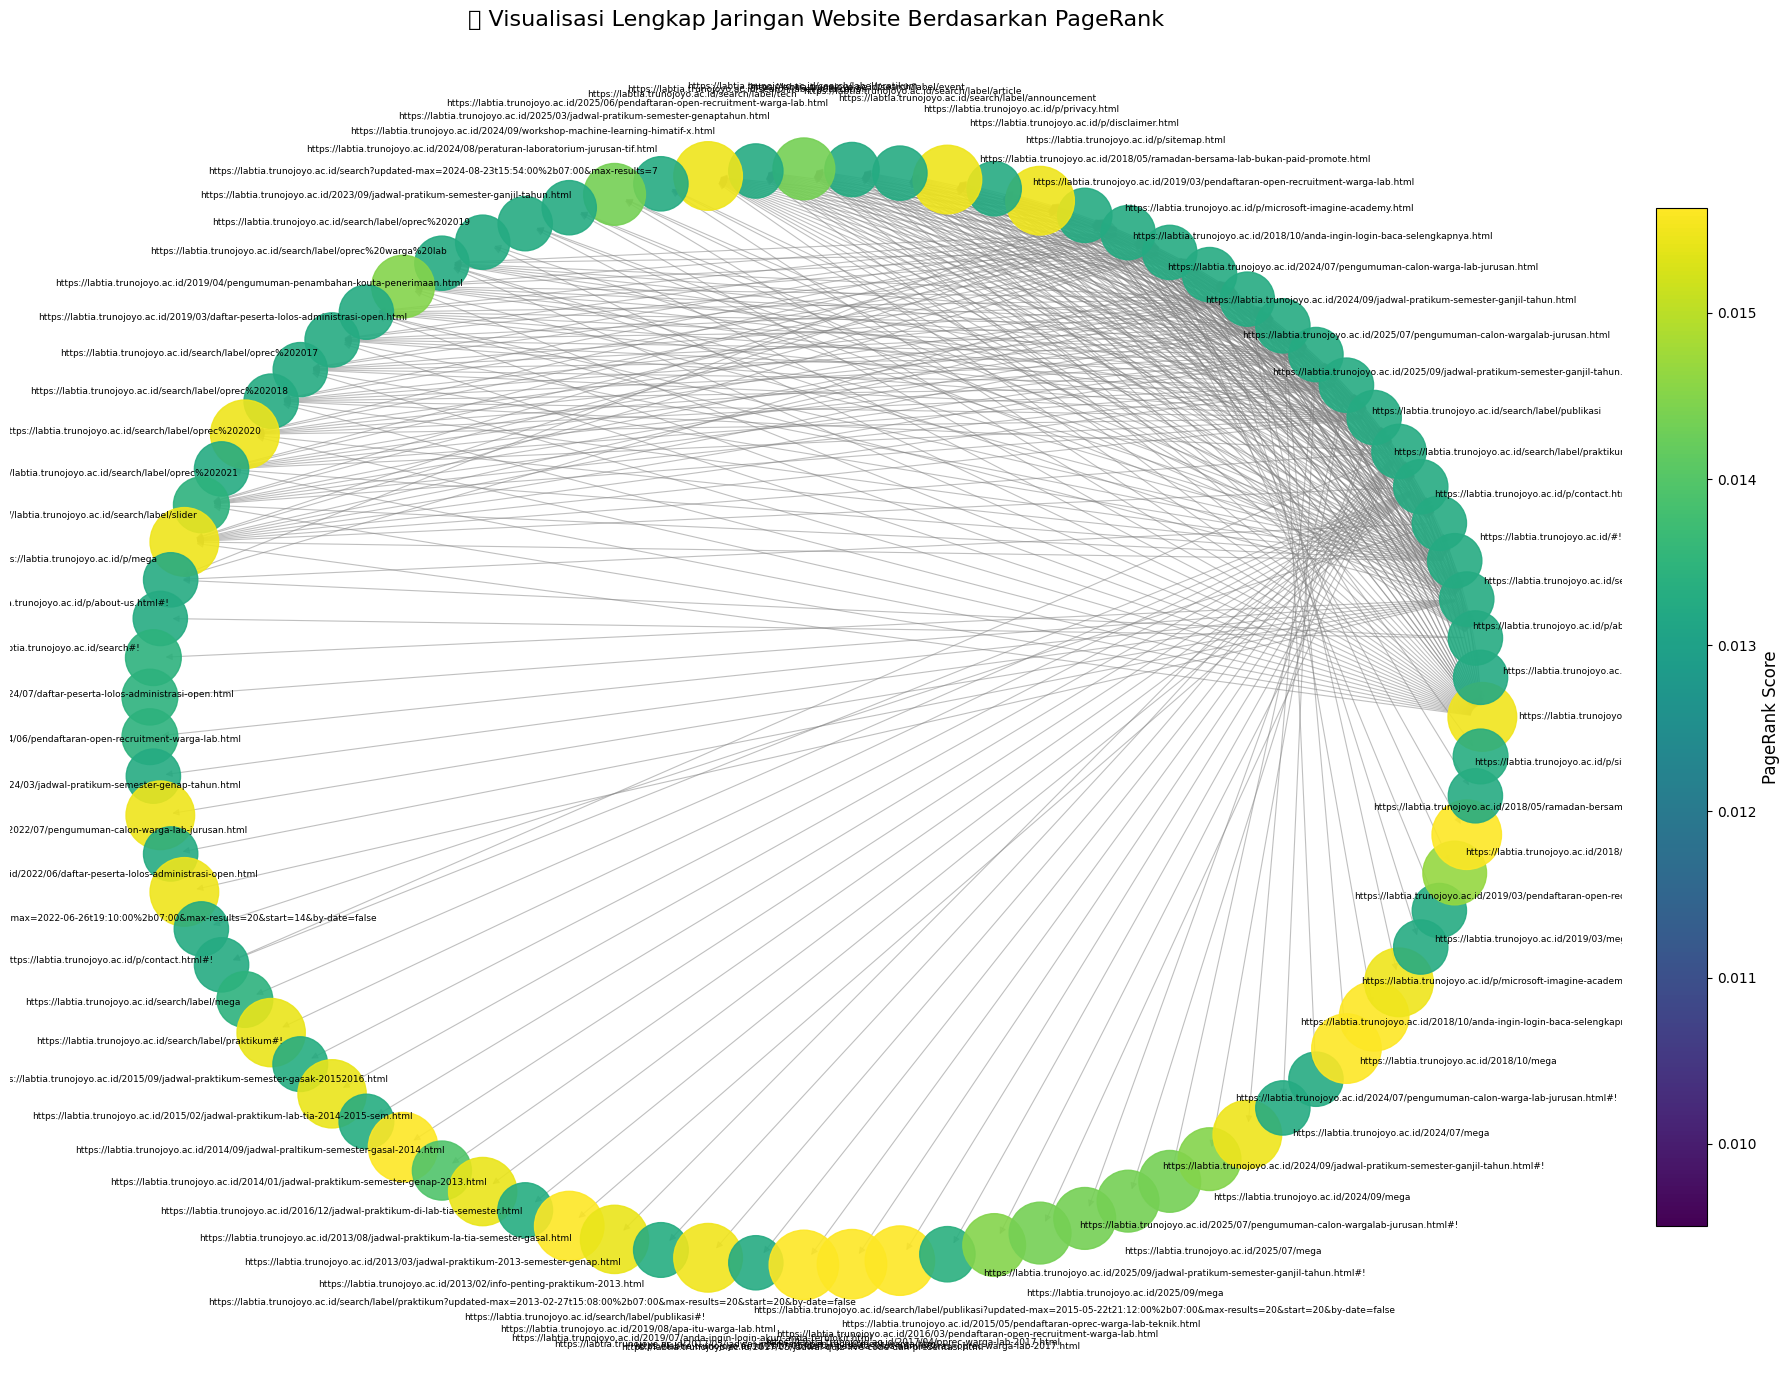


✅ Grafik lengkap tersimpan sebagai 'pagerank_full_graph_with_labels.png'


In [32]:
# === 🧹 Bersihkan dan normalisasi URL (jaga-jaga kalau belum dilakukan) ===
data = data.drop_duplicates(subset=['source_url', 'target_url'])
data = data[data['source_url'] != data['target_url']]
data['source_url'] = data['source_url'].str.strip().str.lower().str.rstrip('/')
data['target_url'] = data['target_url'].str.strip().str.lower().str.rstrip('/')
data['source_url'] = data['source_url'].str.replace('http://', 'https://', regex=False)
data['target_url'] = data['target_url'].str.replace('http://', 'https://', regex=False)

print(f"✅ Total edges bersih: {len(data)}")
print(f"✅ Total node unik: {len(set(data['source_url']) | set(data['target_url']))}")

# === 🔹 Fungsi PageRank manual ===
def pagerank(adj_matrix, d=0.85, max_iter=100, tol=1e-6):
    """
    Hitung PageRank dari matriks adjacency.
    """
    adj = np.array(adj_matrix, dtype=float)
    n = adj.shape[0]

    # Tangani dangling nodes (baris tanpa outlink)
    out_degree = np.sum(adj, axis=1)
    for i in range(n):
        if out_degree[i] == 0:
            adj[i, :] = 1.0  # taut ke semua halaman

    # Normalisasi baris → jadi matriks transisi
    M = adj / np.sum(adj, axis=1, keepdims=True)
    M = M.T  # Sekarang M[j,i] = probabilitas dari i ke j

    # Inisialisasi nilai awal
    r = np.ones(n) / n
    teleport = (1 - d) / n

    for _ in range(max_iter):
        r_new = d * M @ r + teleport
        if np.linalg.norm(r_new - r, 1) < tol:
            break
        r = r_new

    return r

# === 🌐 Buat graf terarah ===
G = nx.DiGraph()
G.add_edges_from(data[['source_url', 'target_url']].values)

# === 🔹 Buat matriks adjacency ===
nodes = sorted(G.nodes())
node_index = {node: idx for idx, node in enumerate(nodes)}
n = len(nodes)
adj_matrix = np.zeros((n, n))

for u, v in G.edges():
    adj_matrix[node_index[u], node_index[v]] = 1

# === 🔹 Hitung PageRank ===
pr_scores = pagerank(adj_matrix)
pr_dict = {nodes[i]: score for i, score in enumerate(pr_scores)}

# === 🔹 Urutkan top 10 node ===
top_nodes = sorted(pr_dict.items(), key=lambda x: x[1], reverse=True)[:10]
top_df = pd.DataFrame(top_nodes, columns=['URL', 'PageRank'])

print("\n🌐 10 Halaman Terpenting berdasarkan PageRank:")
display(top_df)

# === 🎨 VISUALISASI SELURUH GRAF DENGAN LABEL URL ===
# Buat figure dan axes eksplisit agar colorbar tidak error
fig, ax = plt.subplots(figsize=(18, 14))

# Layout circular agar semua node menyebar rapi
pos = nx.circular_layout(G)

# Ambil nilai PageRank
pr_values = np.array(list(pr_dict.values()))
node_sizes = 2500 * (pr_values / pr_values.max())
node_colors = plt.cm.viridis(pr_values / pr_values.max())

# Gambar node & edge di axes spesifik
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.9, ax=ax)
nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, alpha=0.5, width=0.8, ax=ax)

# === 🏷️ Tambahkan label URL di semua node ===
labels = {node: node for node in G.nodes()}
label_positions = {}
radius = 1.15  # teks sedikit di luar lingkaran

for node, (x, y) in pos.items():
    angle = np.arctan2(y, x)
    label_positions[node] = (radius * np.cos(angle), radius * np.sin(angle))

nx.draw_networkx_labels(
    G, label_positions, labels=labels,
    font_size=6.5, font_color='black', verticalalignment='center', ax=ax
)
# === 🌈 Tambahkan colorbar dan judul ===
sm = plt.cm.ScalarMappable(
    cmap=plt.cm.viridis,
    norm=plt.Normalize(vmin=pr_values.min(), vmax=pr_values.max())
)
sm._A = []
cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.02)
cbar.set_label("PageRank Score", fontsize=12)

ax.set_title("🌐 Visualisasi Lengkap Jaringan Website Berdasarkan PageRank", fontsize=16, pad=20)
ax.axis("off")
plt.tight_layout()

# === 💾 Simpan hasil visualisasi ke file HD ===
plt.savefig("pagerank_full_graph_with_labels.png", dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Grafik lengkap tersimpan sebagai 'pagerank_full_graph_with_labels.png'")


=== 5 Node Terpenting berdasarkan PageRank ===
Node https://labtia.trunojoyo.ac.id/search/label/tech: 0.0156
Node https://labtia.trunojoyo.ac.id/p/disclaimer.html: 0.0156
Node https://labtia.trunojoyo.ac.id/p/privacy.html: 0.0156
Node https://labtia.trunojoyo.ac.id/search/label/announcement: 0.0156
Node https://labtia.trunojoyo.ac.id/search/label/article: 0.0156

Node https://labtia.trunojoyo.ac.id/search/label/tech:
  → Terhubung ke (outgoing): Tidak ada
  ← Dihubungi oleh (incoming): ['https://labtia.trunojoyo.ac.id', 'https://labtia.trunojoyo.ac.id/p/about-us.html', 'https://labtia.trunojoyo.ac.id/search', 'https://labtia.trunojoyo.ac.id/#!', 'https://labtia.trunojoyo.ac.id/p/contact.html', 'https://labtia.trunojoyo.ac.id/search/label/praktikum', 'https://labtia.trunojoyo.ac.id/search/label/publikasi', 'https://labtia.trunojoyo.ac.id/2025/09/jadwal-pratikum-semester-ganjil-tahun.html', 'https://labtia.trunojoyo.ac.id/2025/07/pengumuman-calon-wargalab-jurusan.html', 'https://labtia.t

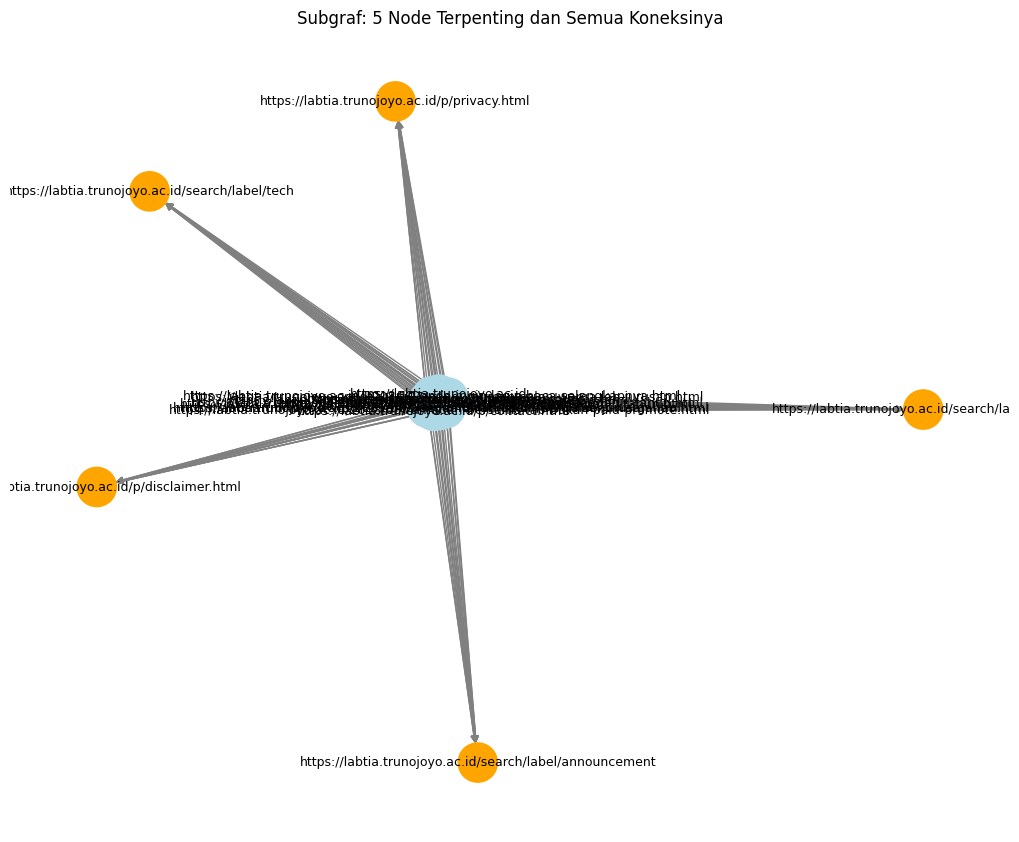

In [12]:
pr_dict = {nodes[i]: score for i, score in enumerate(pr_scores)}
top_5_nodes = sorted(pr_dict.items(), key=lambda x: x[1], reverse=True)[:5]
top_nodes = [node for node, _ in top_5_nodes]

print("=== 5 Node Terpenting berdasarkan PageRank ===")
for node, score in top_5_nodes:
    print(f"Node {node}: {score:.4f}")

connected_nodes = set()
for node in top_nodes:
    neighbors_out = list(G.successors(node))
    neighbors_in = list(G.predecessors(node))

    print(f"\nNode {node}:")
    print(f"  → Terhubung ke (outgoing): {neighbors_out if neighbors_out else 'Tidak ada'}")
    print(f"  ← Dihubungi oleh (incoming): {neighbors_in if neighbors_in else 'Tidak ada'}")

    connected_nodes.update(neighbors_out)
    connected_nodes.update(neighbors_in)

connected_nodes.update(top_nodes)

subG = G.subgraph(connected_nodes).copy()

edges_involving_top = [e for e in G.edges() if e[0] in top_nodes or e[1] in top_nodes]
print(f"\nJumlah total koneksi (edges) yang melibatkan 5 node terpenting: {len(edges_involving_top)}")

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(subG, seed=42)
node_colors = ['orange' if n in top_nodes else 'lightblue' for n in subG.nodes()]

nx.draw(
    subG,
    pos,
    with_labels=True,
    node_size=800,
    font_size=9,
    node_color=node_colors,
    edge_color='gray',
    arrows=True
)

plt.title("Subgraf: 5 Node Terpenting dan Semua Koneksinya")
plt.show()